**ReadMe:**


The code can be directly run sequentially in thie notebook. Please put the data in the same root of the notebook, i.e. the data folders should be at 'data/ORL' and 'data/CroppedYaleB'. The running results are also saved in the zip file. Please command out the running cells and directly run the loading cells to read the results, as some of the cells have a very long running time.

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

## 1. Load Dataset

### 1.1 Data Folder

In [ ]:
# The structure of data folder.
!ls -l data

'ls' is not recognized as an internal or external command,
operable program or batch file.



\# Tree structure of data folder. ├── CroppedAR ├── M-001-01.bmp ├──
M-001-01.txt ├── M-001-02.bmp ├── M-001-02.txt ├── ... ├── CroppedYaleB
│ ├── yaleB01 │ ├── yaleB02 │ ... │ ├── yaleB38 │ └── yaleB39 └── ORL
├── s1 ├── s2 ├── s3 ├── ... ├── s40

### 1.2 Load ORL Dataset and Extended YaleB Dataset.

-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [ ]:
def load_data(root='data/CroppedYaleB', reduce=4, resize_shape = [30, 37]):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            # Convert the image size to the desired size
            img = img.resize(resize_shape)

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Load the ORL dataset
X_ORL, Y_ORL = load_data(root='data/ORL', reduce=2, resize_shape = [30, 37])
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_ORL.shape, Y_ORL.shape))

# Load the Extended YaleB dataset.
X_YaleB, Y_YaleB = load_data(root='data/CroppedYaleB', reduce=4, resize_shape = [42, 48])
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_YaleB.shape, Y_YaleB.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)



### 1.3 Load AR Dataset (Optional)

AR dataset contains 2600 images of 100 individuals (50 male and 50
female). All images have been cropped and resized to 120x165 pixels. To
further reduce the computation complexity, you can resize all images to
40x55 pixels.

In [ ]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """ 
    Load AR dataset to numpy array.
    
    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    
    for fname in os.listdir(root):
        
        if not fname.endswith('.bmp'):
            continue
        
        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50
        
        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey
        
        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])
    
        # TODO: preprocessing.
        # Resize the image from 120x165 to 40x55
        img = img.resize([s//reduce for s in img.size])
        
        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))
        
        # collect data and label.
        images.append(img)
        labels.append(label)
        
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    
    return images, labels

## 2. NMF algorithms

### 2.1 Frobenius-Norm NMF

In [ ]:
def mf_multiplicative_update_L2(X, k, max_steps=5000, random_state = True):
    # X is in R^{d x n}
    # D is in R_{+}^{d x k}
    # R is in R_{+}^{k x n}
    d = len(X)
    n = len(X[0])

    # initialize

    # For a fixed starting of D and R
    if  random_state == True:
        rng = np.random.RandomState(1)
        D = rng.rand(d, k)
        R = rng.rand(k, n)
    
    # For a random starting of D and R
    else:
        D = np.random.rand(d, k)
        R = np.random.rand(k, n)

    for step in range(max_steps):
        # Fix D^k, solve for R^{k+1}
        Ru = R * (D.T.dot(X)) / (D.T.dot(D).dot(R)) + 1e-7

        # Fix R^{k+1}, solve for D^{k+1}
        Du = D * (X.dot(Ru.T)) / (D.dot(Ru).dot(Ru.T)) + 1e-7

        e_R = np.sqrt(np.sum((Ru-R)**2, axis=(0,1)))/R.size
        e_D = np.sqrt(np.sum((Du-D)**2, axis=(0,1)))/D.size
            
        if e_R<0.00001 and e_D<0.00001:
            break
        R = Ru
        D = Du
    return D, R, step

#### 2.1.1 Hyperparameter k exploration - ORL dataset

In [ ]:
# Create a list of potential options of k
k_list = [i for i in range(1, 101)]

# Create an empty RRE list and step list to gather data
RRE_list = []
step_list = []

# Loop for different k values 
for k in k_list:
    # Obtain the D, R matrics and the steps
    D_ORL, R_ORL, step = mf_multiplicative_update_L2(X = X_ORL, k = k, max_steps = 5000, random_state = True)

    # Calculate the RRE
    RRE = np.linalg.norm(X_ORL - D_ORL.dot(R_ORL)) / np.linalg.norm(X_ORL)

    # Store the data
    RRE_list.append(RRE)
    step_list.append(step)

    # Show the progress
    if k % 10 == 0:
        print('k = {} out of 100 has been done.'.format(k))

k = 10 out of 100 has been done.
k = 20 out of 100 has been done.
k = 30 out of 100 has been done.
k = 40 out of 100 has been done.
k = 50 out of 100 has been done.
k = 60 out of 100 has been done.
k = 70 out of 100 has been done.
k = 80 out of 100 has been done.
k = 90 out of 100 has been done.
k = 100 out of 100 has been done.


In [ ]:
# Save the list using numpy.save

RRE_list = np.array(RRE_list)
step_list = np.array(step_list)

with open('RRE_list_ORL_L2.npy', 'wb') as f:
    np.save(f, RRE_list)

with open('step_list_ORL_L2.npy', 'wb') as f:
    np.save(f, step_list)

#### 2.1.2 Hyperparameter k exploration - Extended YaleB dataset

In [ ]:
# Create a list of potential options of k
k_list = [i for i in range(1, 101)]

# Create an empty RRE list and step list to gather data
RRE_list = []
step_list = []

# Loop for different k values
for k in k_list:
    # Obtain the D, R matrics and the steps
    D_YaleB, R_YaleB, step = mf_multiplicative_update_L2(X = X_YaleB, k = k, max_steps = 5000, random_state = True)

    # Calculate the RRE
    RRE = np.linalg.norm(X_YaleB - D_YaleB.dot(R_YaleB)) / np.linalg.norm(X_YaleB)

    # Store the data
    RRE_list.append(RRE)
    step_list.append(step)

    # Show the progress
    if k % 10 == 0:
        print('k = {} out of 100 has been done.'.format(k))

k = 10 out of 100 has been done.
k = 20 out of 100 has been done.
k = 30 out of 100 has been done.
k = 40 out of 100 has been done.
k = 50 out of 100 has been done.
k = 60 out of 100 has been done.
k = 70 out of 100 has been done.
k = 80 out of 100 has been done.
k = 90 out of 100 has been done.
k = 100 out of 100 has been done.


In [ ]:
# Save the arrays using numpy.save

RRE_list = np.array(RRE_list)
step_list = np.array(step_list)

with open('RRE_list_YaleB_L2.npy', 'wb') as f:
    np.save(f, RRE_list)

with open('step_list_YaleB_L2.npy', 'wb') as f:
    np.save(f, step_list)

#### 2.1.2 Hyperparameter k exploration - Visualization

In [ ]:
# Load the arrays

k_list = np.array([i for i in range(1, 101)])

with open('RRE_list_ORL_L2.npy', 'rb') as f:
    RRE_list_ORL = np.load(f)

with open('step_list_ORL_L2.npy', 'rb') as f:
    step_list_ORL = np.load(f)

with open('RRE_list_YaleB_L2.npy', 'rb') as f:
    RRE_list_YaleB = np.load(f)

with open('step_list_YaleB_L2.npy', 'rb') as f:
    step_list_YaleB = np.load(f)

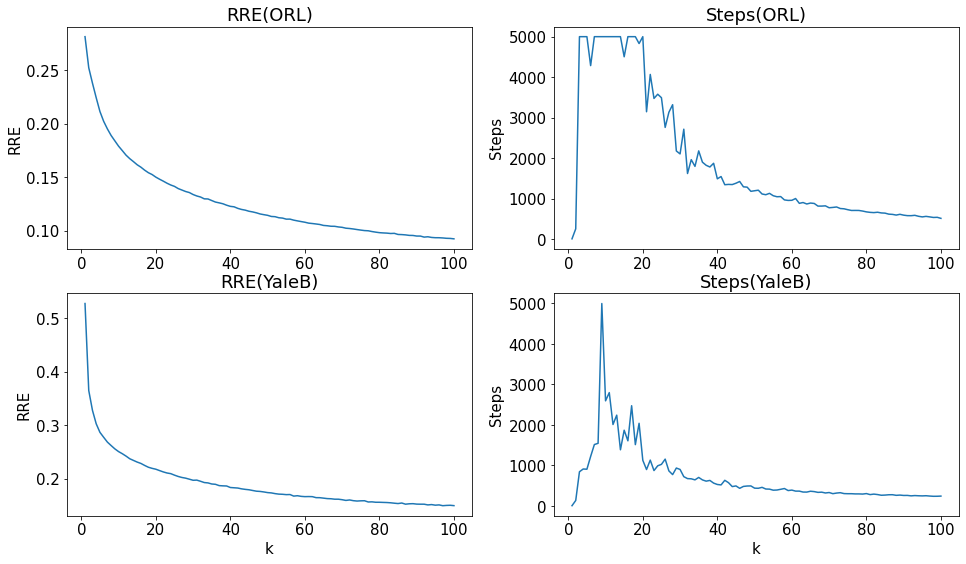

In [ ]:
# Plot the figures for exploration of k
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams.update({'font.size': 15})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(k_list, RRE_list_ORL)
ax1.set_title('RRE(ORL)')
ax1.set(ylabel='RRE')

ax2.plot(k_list, step_list_ORL)
ax2.set_title('Steps(ORL)')
ax2.set( ylabel='Steps')

ax3.plot(k_list, RRE_list_YaleB)
ax3.set_title('RRE(YaleB)')
ax3.set(xlabel='k', ylabel='RRE')

ax4.plot(k_list, step_list_YaleB)
ax4.set_title('Steps(YaleB)')
ax4.set(xlabel='k', ylabel='Steps')

plt.savefig('hyper_k_L2.pdf')
plt.show()

In [ ]:
# Set a threshold for finding the "optimal" k
Threshold = -0.001

# Start with k = 1
opt_k_ORL = 1
opt_k_YaleB = 1

# Loop to find the "optimal" k
for k in range(1, 100):
    RRE_diff = RRE_list_ORL[k+1] - RRE_list_ORL[k]
    if RRE_diff > Threshold:
        opt_k_ORL = k
        break
# Loop to find the "optimal" k
for k in range(1, 100):
    RRE_diff = RRE_list_YaleB[k+1] - RRE_list_YaleB[k]
    if RRE_diff > Threshold:
        opt_k_YaleB = k
        break
print("The optimal k of the ORL dataset is:", opt_k_ORL)
print("The optimal k of the YaleB dataset is:", opt_k_YaleB)

The optimal k of the ORL dataset is: 27
The optimal k of the YaleB dataset is: 29


In [ ]:
opt_k_ORL = 27
opt_k_YaleB = 29

### 2.2 L_{2, 1}-Norm NMF

In [ ]:
def mf_multiplicative_update_L21(X, k, max_steps=5000, random_state = True):
    # X is in R^{d x n}
    # D is in R_{+}^{d x k}
    # R is in R_{+}^{k x n}
    d = len(X)
    n = len(X[0])

    # initialize

    # For a fixed starting of D and R
    if  random_state == True:
        rng = np.random.RandomState(1)
        D = rng.rand(d, k)
        R = rng.rand(k, n)
    
    # For a random starting of D and R
    else:
        D = np.random.rand(d, k)
        R = np.random.rand(k, n)

    for step in range(max_steps):
        # Create the diagonal matrix Q 
        X_DR = X - D.dot(R)
        Q = np.diag(np.sqrt(np.sum(X_DR ** 2, axis = 0)))
        
        # Fix Q^k and D^k, solve for R^{k+1}
        Ru = R * (D.T.dot(X).dot(Q)) / (D.T.dot(D).dot(R).dot(Q)) + 1e-7

        # Fix Q^k and R^{k+1} , solve for D^{k+1}
        Du = D * (X.dot(Q).dot(Ru.T)) / (D.dot(Ru).dot(Q).dot(Ru.T)) + 1e-7

        e_R = np.sqrt(np.sum((Ru-R)**2, axis=(0,1)))/R.size
        e_D = np.sqrt(np.sum((Du-D)**2, axis=(0,1)))/D.size
                
        if e_R<0.00001 and e_D<0.00001:
            break
        R = Ru
        D = Du
    return D, R, step

## 3. Noise generation

### 3.1 Random addition noise

In [ ]:
# Generate the noise with random integer in range(0, 40)
add_noise_ORL = np.random.rand(*X_ORL.shape) * 40
add_noise_YaleB = np.random.rand(*X_YaleB.shape) * 40

# Add Noise.
X_add_noise_ORL = X_ORL.copy() + add_noise_ORL
X_add_noise_YaleB = X_YaleB.copy() + add_noise_YaleB

==> ORL dataset visualization


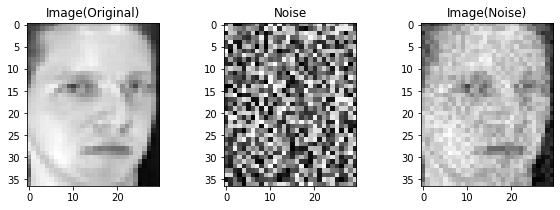

In [ ]:
# Visualization for ORL dataset

print('==> ORL dataset visualization')
img_size = [30, 37] # ORL (30, 37)
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(add_noise_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(X_add_noise_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.savefig('ORL_random_noise.pdf')
plt.show()

==> YaleB dataset visualization


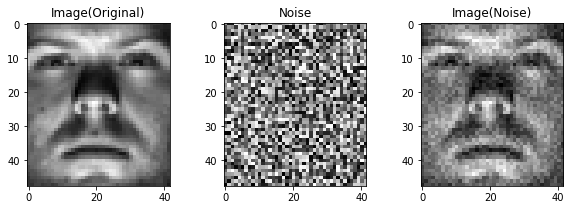

In [ ]:
# Visualization for YaleB dataset 

print('==> YaleB dataset visualization')
img_size = [42, 48] # ORL (42, 48)
ind = 5 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(add_noise_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(X_add_noise_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.savefig('YaleB_random_noise.pdf')
plt.show()

### 3.2 Block-occlusion noise

In [ ]:
# Noise generation for ORL dataset

bc_noise_ORL = np.zeros((X_ORL.shape))

# The image size for ORL
img_size = [30, 37] # ORL (30, 37)

# Reshape the noise array into a 3-D form
bc_noise_ORL = np.reshape(bc_noise_ORL, (img_size[1], img_size[0], X_ORL.shape[1]))

b = 10
for i in range(X_ORL.shape[1]):

    # The upper-left position of the box (random)
    x_pos = np.random.randint(low = 0, high = img_size[1] - b + 1)

    # The lower-left position of the box (random)
    y_pos = np.random.randint(low = 0, high = img_size[0] - b + 1)

    #change the pixel values in the box to 255
    bc_noise_ORL[:, :, i][x_pos:x_pos+b, y_pos:y_pos+b] = 255

# Reshape the noise array into a 2-D form
bc_noise_ORL = bc_noise_ORL.reshape((X_ORL.shape))

# Add Noise
X_bc_noise_ORL = X_ORL.copy() + bc_noise_ORL

# Clip the values to the interval of [0, 255]
X_bc_noise_ORL = np.clip(X_bc_noise_ORL, 0, 255)

# Change the dtype to uint8 
X_bc_noise_ORL = X_bc_noise_ORL.astype('uint8')

==> ORL dataset visualization


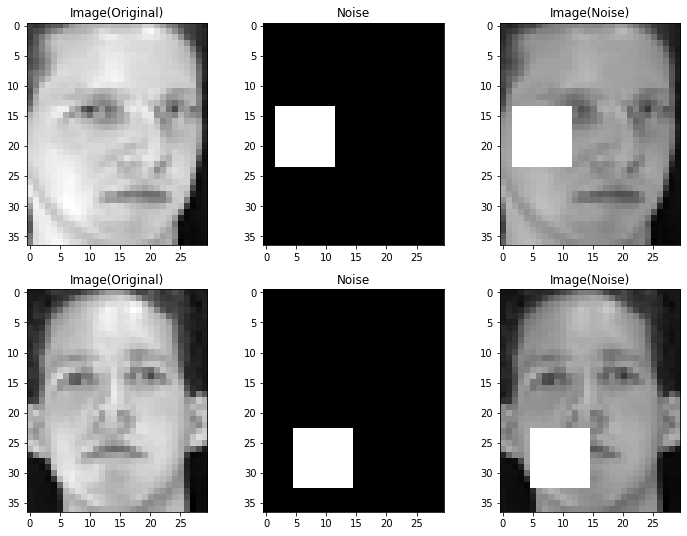

In [ ]:
# Visualization for ORL dataset 

print('==> ORL dataset visualization')
img_size = [i//3 for i in (92, 112)] # ORL (30, 37)
ind = 2 # index of demo image.
plt.figure(figsize=(12,9))
plt.subplot(231)
plt.imshow(X_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(232)
plt.imshow(bc_noise_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(233)
plt.imshow(X_bc_noise_ORL[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

# plot another demo image to show the random box
plt.subplot(234)
plt.imshow(X_ORL[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(235)
plt.imshow(bc_noise_ORL[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(236)
plt.imshow(X_bc_noise_ORL[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.savefig('ORL_occlusion_noise.pdf')
plt.show()

In [ ]:
# Noise generation for YaleB dataset

bc_noise_YaleB = np.zeros((X_YaleB.shape))

# The image size for YaleB
img_size = [42, 48] # YaleB (42, 48)

# Reshape the noise array into a 3-D form
bc_noise_YaleB = np.reshape(bc_noise_YaleB, (img_size[1], img_size[0], X_YaleB.shape[1]))

b = 10
for i in range(X_YaleB.shape[1]):

    # The upper-left position of the box (random)
    x_pos = np.random.randint(low = 0, high = img_size[1] - b + 1)

    # The lower-left position of the box (random)
    y_pos = np.random.randint(low = 0, high = img_size[0] - b + 1)

    #change the pixel values in the box to 255
    bc_noise_YaleB[:, :, i][x_pos:x_pos+b, y_pos:y_pos+b] = 255

# Reshape the noise array into a 2-D form
bc_noise_YaleB = bc_noise_YaleB.reshape((X_YaleB.shape))

# Add Noise
X_bc_noise_YaleB = X_YaleB.copy() + bc_noise_YaleB

# Clip the values to the interval of [0, 255]
X_bc_noise_YaleB = np.clip(X_bc_noise_YaleB, 0, 255)

# Change the dtype to uint8 
X_bc_noise_YaleB = X_bc_noise_YaleB.astype('uint8')

==> YaleB dataset visualization


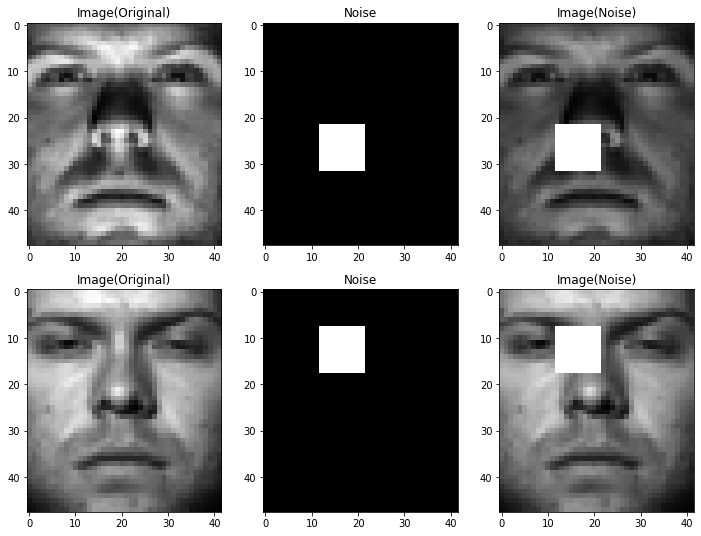

In [ ]:
# Visualization for YaleB dataset 

print('==> YaleB dataset visualization')
img_size = [42, 48] # YaleB (42, 48)
ind = 5 # index of demo image.
plt.figure(figsize=(12,9))
plt.subplot(231)
plt.imshow(X_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(232)
plt.imshow(bc_noise_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(233)
plt.imshow(X_bc_noise_YaleB[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')

# plot another demo image to show the random box
plt.subplot(234)
plt.imshow(X_YaleB[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(235)
plt.imshow(bc_noise_YaleB[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(236)
plt.imshow(X_bc_noise_YaleB[:,ind+5].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.savefig('YaleB_occlusion_noise.pdf')
plt.show()

## 3. Evaluation Metrics

### 3.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$

### 3.2 Evaluate Clustering Performance
Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.


#### 3.3.1 ORL dataset

In [ ]:
# Define the clustering function using K-means from sklearn
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


In [ ]:
print('==> Start evaluation NMF(Frobenius norm) ...')

# Create empty lists for data collection
RRE_list_ORL_L2 = []
RRE_add_list_ORL_L2 = []
RRE_bc_list_ORL_L2 = []

acc_list_ORL_L2 = []
acc_add_list_ORL_L2 = []
acc_bc_list_ORL_L2 = []

nmi_list_ORL_L2 = []
nmi_add_list_ORL_L2 = []
nmi_bc_list_ORL_L2 = []

for i in range(1, 101):
#==========================================================================================================================================
    # Without noise
    D_ORL, R_ORL, step = mf_multiplicative_update_L2(X = X_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE = np.linalg.norm(X_ORL - D_ORL.dot(R_ORL)) / np.linalg.norm(X_ORL)
    RRE_list_ORL_L2.append(RRE)
    
    # # Assign cluster labels.
    Y_pred = assign_cluster_label(R_ORL.T, Y_ORL)
    # Calculate the accuracy
    acc = accuracy_score(Y_ORL, Y_pred)
    acc_list_ORL_L2.append(acc)
    # Calculate the NMI
    nmi = normalized_mutual_info_score(Y_ORL, Y_pred)
    nmi_list_ORL_L2.append(nmi)

#==========================================================================================================================================
    # With random addition noise
    D_add_ORL, R_add_ORL, step = mf_multiplicative_update_L2(X = X_add_noise_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE_add = np.linalg.norm(X_ORL - D_add_ORL.dot(R_add_ORL)) / np.linalg.norm(X_ORL)
    RRE_add_list_ORL_L2.append(RRE_add)

    # # Assign cluster labels.
    Y_pred_add = assign_cluster_label(R_add_ORL.T, Y_ORL)
    # Calculate the accuracy
    acc_add = accuracy_score(Y_ORL, Y_pred_add)
    acc_add_list_ORL_L2.append(acc_add)
    # Calculate the NMI
    nmi_add = normalized_mutual_info_score(Y_ORL, Y_pred_add)
    nmi_add_list_ORL_L2.append(nmi_add)

#==========================================================================================================================================
    # With block-occulusion noise
    D_bc_ORL, R_bc_ORL, step = mf_multiplicative_update_L2(X = X_bc_noise_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE_bc = np.linalg.norm(X_ORL - D_bc_ORL.dot(R_bc_ORL)) / np.linalg.norm(X_ORL)
    RRE_bc_list_ORL_L2.append(RRE_bc)

    # # Assign cluster labels.
    Y_pred_bc = assign_cluster_label(R_bc_ORL.T, Y_ORL)
    # Calculate the accuracy
    acc_bc = accuracy_score(Y_ORL, Y_pred_bc)
    acc_bc_list_ORL_L2.append(acc_bc)
    # Calculate the NMI
    nmi_bc = normalized_mutual_info_score(Y_ORL, Y_pred_bc)
    nmi_bc_list_ORL_L2.append(nmi_bc)

#==========================================================================================================================================
    if i%10 == 0:
        print('i = {} out of 100 has been done.'.format(i))

==> Start evaluation NMF(Frobenius norm) ...
i = 10 out of 100 has been done.
i = 20 out of 100 has been done.
i = 30 out of 100 has been done.
i = 40 out of 100 has been done.
i = 50 out of 100 has been done.
i = 60 out of 100 has been done.
i = 70 out of 100 has been done.
i = 80 out of 100 has been done.
i = 90 out of 100 has been done.
i = 100 out of 100 has been done.


In [ ]:
# Save all the results for NMF(Frobenius norm)

RREs = np.array([RRE_list_ORL_L2, RRE_add_list_ORL_L2, RRE_bc_list_ORL_L2])
accs = np.array([acc_list_ORL_L2, acc_add_list_ORL_L2, acc_bc_list_ORL_L2])
nmis = np.array([nmi_list_ORL_L2, nmi_add_list_ORL_L2, nmi_bc_list_ORL_L2])

with open('RREs_L2_ORL.npy', 'wb') as f:
    np.save(f, RREs)

with open('accs_L2_ORL.npy', 'wb') as f:
    np.save(f, accs)

with open('nmis_L2_ORL.npy', 'wb') as f:
    np.save(f, nmis)

In [ ]:
# Repeat the process for L_{2, 1} Norm
print('==> Start evaluation NMF(L_{2, 1} norm) ...')
RRE_list_ORL_L21 = []
RRE_add_list_ORL_L21 = []
RRE_bc_list_ORL_L21 = []

acc_list_ORL_L21 = []
acc_add_list_ORL_L21 = []
acc_bc_list_ORL_L21 = []

nmi_list_ORL_L21 = []
nmi_add_list_ORL_L21 = []
nmi_bc_list_ORL_L21 = []

for i in range(1, 101):
#==========================================================================================================================================
    # Without noise
    D_ORL, R_ORL, step = mf_multiplicative_update_L21(X = X_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE = np.linalg.norm(X_ORL - D_ORL.dot(R_ORL)) / np.linalg.norm(X_ORL)
    RRE_list_ORL_L21.append(RRE)
    
    # # Assign cluster labels.
    Y_pred = assign_cluster_label(R_ORL.T, Y_ORL)
    acc = accuracy_score(Y_ORL, Y_pred)
    acc_list_ORL_L21.append(acc)
    nmi = normalized_mutual_info_score(Y_ORL, Y_pred)
    nmi_list_ORL_L21.append(nmi)

#==========================================================================================================================================
    # With random addition noise
    D_add_ORL, R_add_ORL, step = mf_multiplicative_update_L21(X = X_add_noise_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE_add = np.linalg.norm(X_ORL - D_add_ORL.dot(R_add_ORL)) / np.linalg.norm(X_ORL)
    RRE_add_list_ORL_L21.append(RRE_add)

    # # Assign cluster labels.
    Y_pred_add = assign_cluster_label(R_add_ORL.T, Y_ORL)
    acc_add = accuracy_score(Y_ORL, Y_pred_add)
    acc_add_list_ORL_L21.append(acc_add)
    nmi_add = normalized_mutual_info_score(Y_ORL, Y_pred_add)
    nmi_add_list_ORL_L21.append(nmi_add)

#==========================================================================================================================================
    # With block-occulusion noise
    D_bc_ORL, R_bc_ORL, step = mf_multiplicative_update_L21(X = X_bc_noise_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
    RRE_bc = np.linalg.norm(X_ORL - D_bc_ORL.dot(R_bc_ORL)) / np.linalg.norm(X_ORL)
    RRE_bc_list_ORL_L21.append(RRE_bc)

    # # Assign cluster labels.
    Y_pred_bc = assign_cluster_label(R_bc_ORL.T, Y_ORL)
    acc_bc = accuracy_score(Y_ORL, Y_pred_bc)
    acc_bc_list_ORL_L21.append(acc_bc)
    nmi_bc = normalized_mutual_info_score(Y_ORL, Y_pred_bc)
    nmi_bc_list_ORL_L21.append(nmi_bc)

#==========================================================================================================================================
    if i%10 == 0:
        print('i = {} out of 100 has been done.'.format(i))

==> Start evaluation NMF(L_{2, 1} norm) ...
i = 10 out of 100 has been done.
i = 20 out of 100 has been done.
i = 30 out of 100 has been done.
i = 40 out of 100 has been done.
i = 50 out of 100 has been done.
i = 60 out of 100 has been done.
i = 70 out of 100 has been done.
i = 80 out of 100 has been done.
i = 90 out of 100 has been done.
i = 100 out of 100 has been done.


In [ ]:
# Save all the results for NMF(L_{2, 1} norm)

RREs = np.array([RRE_list_ORL_L21, RRE_add_list_ORL_L21, RRE_bc_list_ORL_L21])
accs = np.array([acc_list_ORL_L21, acc_add_list_ORL_L21, acc_bc_list_ORL_L21])
nmis = np.array([nmi_list_ORL_L21, nmi_add_list_ORL_L21, nmi_bc_list_ORL_L21])

with open('RREs_L21_ORL.npy', 'wb') as f:
    np.save(f, RREs)

with open('accs_L21_ORL.npy', 'wb') as f:
    np.save(f, accs)

with open('nmis_L21_ORL.npy', 'wb') as f:
    np.save(f, nmis)

In [ ]:
# Load the data stored

with open('RREs_L2_ORL.npy', 'rb') as f:
    RREs_L2_ORL = np.load(f, allow_pickle=True)

with open('accs_L2_ORL.npy', 'rb') as f:
    accs_L2_ORL = np.load(f, allow_pickle=True)

with open('nmis_L2_ORL.npy', 'rb') as f:
    nmis_L2_ORL = np.load(f, allow_pickle=True)

with open('RREs_L21_ORL.npy', 'rb') as f:
    RREs_L21_ORL = np.load(f, allow_pickle=True)

with open('accs_L21_ORL.npy', 'rb') as f:
    accs_L21_ORL = np.load(f, allow_pickle=True)

with open('nmis_L21_ORL.npy', 'rb') as f:
    nmis_L21_ORL = np.load(f, allow_pickle=True)

In [ ]:
# Generate a dataframe to visualize the data
df = pd.DataFrame(columns=['ORL(Original)-Frobenius', 'ORL(Add Noise)-Frobenius', 'ORL(Block Noise)-Frobenius', 'ORL(Original)-L_{2, 1}', 'ORL(Add Noise)-L_{2, 1}', 'ORL(Block Noise)-L_{2, 1}'], index=['RRE (mean)', 'RRE (std)', 'Accuracy (mean)', 'Accuracy (std)', 'NMI (mean)', 'NMI (std)'])
df.loc['RRE (mean)'] = [np.mean(RREs_L2_ORL[0]), np.mean(RREs_L2_ORL[1]), np.mean(RREs_L2_ORL[2]), np.mean(RREs_L21_ORL[0]), np.mean(RREs_L21_ORL[1]), np.mean(RREs_L21_ORL[2])]
df.loc['RRE (std)'] = [np.std(RREs_L2_ORL[0]), np.std(RREs_L2_ORL[1]), np.std(RREs_L2_ORL[2]), np.std(RREs_L21_ORL[0]), np.std(RREs_L21_ORL[1]), np.std(RREs_L21_ORL[2])]

df.loc['Accuracy (mean)'] = [np.mean(accs_L2_ORL[0]), np.mean(accs_L2_ORL[1]), np.mean(accs_L2_ORL[2]), np.mean(accs_L21_ORL[0]), np.mean(accs_L21_ORL[1]), np.mean(accs_L21_ORL[2])]
df.loc['Accuracy (std)'] = [np.std(accs_L2_ORL[0]), np.std(accs_L2_ORL[1]), np.std(accs_L2_ORL[2]), np.std(accs_L21_ORL[0]), np.std(accs_L21_ORL[1]), np.std(accs_L21_ORL[2])]

df.loc['NMI (mean)'] = [np.mean(nmis_L2_ORL[0]), np.mean(nmis_L2_ORL[1]), np.mean(nmis_L2_ORL[2]), np.mean(nmis_L21_ORL[0]), np.mean(nmis_L21_ORL[1]), np.mean(nmis_L21_ORL[2])]
df.loc['NMI (std)'] = [np.std(nmis_L2_ORL[0]), np.std(nmis_L2_ORL[1]), np.std(nmis_L2_ORL[2]), np.std(nmis_L21_ORL[0]), np.std(nmis_L21_ORL[1]), np.std(nmis_L21_ORL[2])]

# Save the dataframe into csv file
df.to_csv('data_ORL.csv') 

df

,ORL(Original)-Frobenius,ORL(Add Noise)-Frobenius,ORL(Block Noise)-Frobenius,"ORL(Original)-L_{2, 1}","ORL(Add Noise)-L_{2, 1}","ORL(Block Noise)-L_{2, 1}"
RRE (mean),0.138017,0.215618,0.325805,0.138178,0.21543,0.324561
RRE (std),0.00024,0.000171,0.000348,0.000243,0.000166,0.00034
Accuracy (mean),0.7276,0.73165,0.25765,0.718825,0.72715,0.27385
Accuracy (std),0.023008,0.025187,0.017592,0.025255,0.023391,0.017122
NMI (mean),0.846747,0.848463,0.423083,0.842997,0.846881,0.437489
NMI (std),0.013144,0.01419,0.017817,0.014565,0.013697,0.018118


==> ORL dataset reconstruction visualization


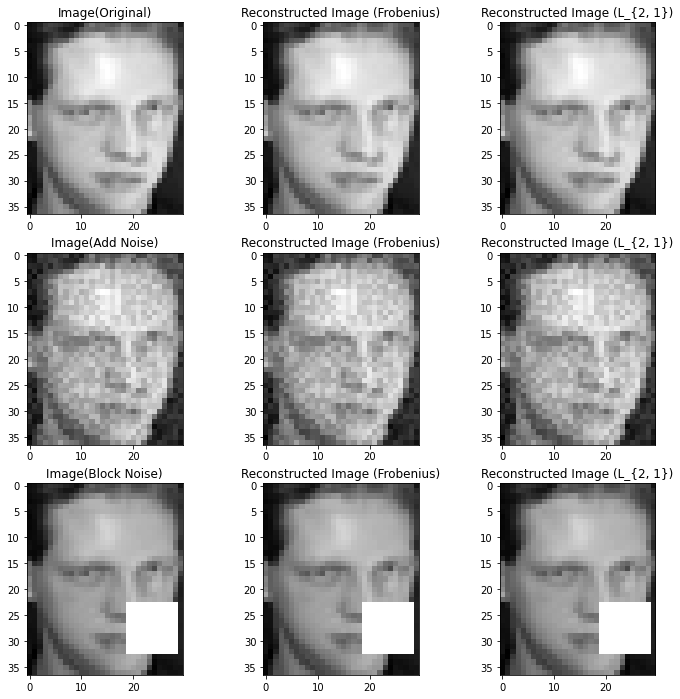

In [ ]:
# Visualization for ORL dataset reconstruction

# Choose an arbitary example from the ORL dataset
sample_ID = 1
# Original
sample_ORL = X_ORL[:, sample_ID].reshape((1, -1))
# With random additional noise
sample_ORl_add = X_add_noise_ORL[:, sample_ID].reshape((1, -1))
# With block noise
sample_ORl_bc = X_bc_noise_ORL[:, sample_ID].reshape((1, -1))

# Reconstruction by Frobenius norm NMF
D_L2, R_L2, _ = mf_multiplicative_update_L2(X = sample_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
D_add_L2, R_add_L2, _ = mf_multiplicative_update_L2(X = sample_ORl_add, k = opt_k_ORL, max_steps = 5000, random_state = False)
D_bc_L2, R_bc_L2, _ = mf_multiplicative_update_L2(X = sample_ORl_bc, k = opt_k_ORL, max_steps = 5000, random_state = False)

re_X = D_L2.dot(R_L2)
re_add_X = D_add_L2.dot(R_add_L2)
re_bc_X = D_bc_L2.dot(R_bc_L2)

# Reconstruction by L_{2, 1} norm NMF
D_L21, R_L21, _ = mf_multiplicative_update_L21(X = sample_ORL, k = opt_k_ORL, max_steps = 5000, random_state = False)
D_add_L21, R_add_L21, _ = mf_multiplicative_update_L21(X = sample_ORl_add, k = opt_k_ORL, max_steps = 5000, random_state = False)
D_bc_L21, R_bc_L21, _ = mf_multiplicative_update_L21(X = sample_ORl_bc, k = opt_k_ORL, max_steps = 5000, random_state = False)

re_L21_X = D_L21.dot(R_L21)
re_add_L21_X = D_add_L21.dot(R_add_L21)
re_bc_L21_X = D_bc_L21.dot(R_bc_L21)

# Visualize the reconstruction results
print('==> ORL dataset reconstruction visualization')
img_size = [30, 37] # ORL (30, 37)
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.imshow(sample_ORL.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(332)
plt.imshow(re_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(333)
plt.imshow(re_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

plt.subplot(334)
plt.imshow(sample_ORl_add.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Add Noise)')
plt.subplot(335)
plt.imshow(re_add_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(336)
plt.imshow(re_add_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

plt.subplot(337)
plt.imshow(sample_ORl_bc.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block Noise)')
plt.subplot(338)
plt.imshow(re_bc_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(339)
plt.imshow(re_bc_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

# Save the figure
plt.savefig('reconstruct_ORL.pdf')
plt.show()

#### 3.3.2 YaleB dataset

In [ ]:
# Repeat the previous process when applying to the YaleB dataset

print('==> Start evaluation NMF(Frobenius norm) ...')
RRE_list_YaleB_L2 = []
RRE_add_list_YaleB_L2 = []
RRE_bc_list_YaleB_L2 = []

acc_list_YaleB_L2 = []
acc_add_list_YaleB_L2 = []
acc_bc_list_YaleB_L2 = []

nmi_list_YaleB_L2 = []
nmi_add_list_YaleB_L2 = []
nmi_bc_list_YaleB_L2 = []

for i in range(1, 101):
#==========================================================================================================================================
    # Without noise
    D_YaleB, R_YaleB, step = mf_multiplicative_update_L2(X = X_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE = np.linalg.norm(X_YaleB - D_YaleB.dot(R_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_list_YaleB_L2.append(RRE)
    
    # # Assign cluster labels.
    Y_pred = assign_cluster_label(R_YaleB.T, Y_YaleB)
    acc = accuracy_score(Y_YaleB, Y_pred)
    acc_list_YaleB_L2.append(acc)
    nmi = normalized_mutual_info_score(Y_YaleB, Y_pred)
    nmi_list_YaleB_L2.append(nmi)

#==========================================================================================================================================
    # With random addition noise
    D_add_YaleB, R_add_YaleB, step = mf_multiplicative_update_L2(X = X_add_noise_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE_add = np.linalg.norm(X_YaleB - D_add_YaleB.dot(R_add_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_add_list_YaleB_L2.append(RRE_add)

    # # Assign cluster labels.
    Y_pred_add = assign_cluster_label(R_add_YaleB.T, Y_YaleB)
    acc_add = accuracy_score(Y_YaleB, Y_pred_add)
    acc_add_list_YaleB_L2.append(acc_add)
    nmi_add = normalized_mutual_info_score(Y_YaleB, Y_pred_add)
    nmi_add_list_YaleB_L2.append(nmi_add)

#==========================================================================================================================================
    # With block-occulusion noise
    D_bc_YaleB, R_bc_YaleB, step = mf_multiplicative_update_L2(X = X_bc_noise_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE_bc = np.linalg.norm(X_YaleB - D_bc_YaleB.dot(R_bc_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_bc_list_YaleB_L2.append(RRE_bc)

    # # Assign cluster labels.
    Y_pred_bc = assign_cluster_label(R_bc_YaleB.T, Y_YaleB)
    acc_bc = accuracy_score(Y_YaleB, Y_pred_bc)
    acc_bc_list_YaleB_L2.append(acc_bc)
    nmi_bc = normalized_mutual_info_score(Y_YaleB, Y_pred_bc)
    nmi_bc_list_YaleB_L2.append(nmi_bc)

#==========================================================================================================================================
    if i%10 == 0:
        print('i = {} out of 100 has been done.'.format(i))

==> Start evaluation NMF(Frobenius norm) ...
i = 10 out of 100 has been done.
i = 20 out of 100 has been done.
i = 30 out of 100 has been done.
i = 40 out of 100 has been done.
i = 50 out of 100 has been done.
i = 60 out of 100 has been done.
i = 70 out of 100 has been done.
i = 80 out of 100 has been done.
i = 90 out of 100 has been done.
i = 100 out of 100 has been done.


In [ ]:
# Save all the results for NMF(Frobenius norm)

RREs = np.array([RRE_list_YaleB_L2, RRE_add_list_YaleB_L2, RRE_bc_list_YaleB_L2])
accs = np.array([acc_list_YaleB_L2, acc_add_list_YaleB_L2, acc_bc_list_YaleB_L2])
nmis = np.array([nmi_list_YaleB_L2, nmi_add_list_YaleB_L2, nmi_bc_list_YaleB_L2])

with open('RREs_L2_YaleB.npy', 'wb') as f:
    np.save(f, RREs)

with open('accs_L2_YaleB.npy', 'wb') as f:
    np.save(f, accs)

with open('nmis_L2_YaleB.npy', 'wb') as f:
    np.save(f, nmis)

In [ ]:
# Repeat the previous process when applying to the YaleB dataset

print('==> Start evaluation NMF(L_{2, 1} norm) ...')
RRE_list_YaleB_L21 = []
RRE_add_list_YaleB_L21 = []
RRE_bc_list_YaleB_L21 = []

acc_list_YaleB_L21 = []
acc_add_list_YaleB_L21 = []
acc_bc_list_YaleB_L21 = []

nmi_list_YaleB_L21 = []
nmi_add_list_YaleB_L21 = []
nmi_bc_list_YaleB_L21 = []

for i in range(1, 101):
#==========================================================================================================================================
    # Without noise
    D_YaleB, R_YaleB, step = mf_multiplicative_update_L21(X = X_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE = np.linalg.norm(X_YaleB - D_YaleB.dot(R_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_list_YaleB_L21.append(RRE)
    
    # # Assign cluster labels.
    Y_pred = assign_cluster_label(R_YaleB.T, Y_YaleB)
    acc = accuracy_score(Y_YaleB, Y_pred)
    acc_list_YaleB_L21.append(acc)
    nmi = normalized_mutual_info_score(Y_YaleB, Y_pred)
    nmi_list_YaleB_L21.append(nmi)

#==========================================================================================================================================
    # With random addition noise
    D_add_YaleB, R_add_YaleB, step = mf_multiplicative_update_L21(X = X_add_noise_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE_add = np.linalg.norm(X_YaleB - D_add_YaleB.dot(R_add_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_add_list_YaleB_L21.append(RRE_add)

    # # Assign cluster labels.
    Y_pred_add = assign_cluster_label(R_add_YaleB.T, Y_YaleB)
    acc_add = accuracy_score(Y_YaleB, Y_pred_add)
    acc_add_list_YaleB_L21.append(acc_add)
    nmi_add = normalized_mutual_info_score(Y_YaleB, Y_pred_add)
    nmi_add_list_YaleB_L21.append(nmi_add)

#==========================================================================================================================================
    # With block-occulusion noise
    D_bc_YaleB, R_bc_YaleB, step = mf_multiplicative_update_L21(X = X_bc_noise_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
    RRE_bc = np.linalg.norm(X_YaleB - D_bc_YaleB.dot(R_bc_YaleB)) / np.linalg.norm(X_YaleB)
    RRE_bc_list_YaleB_L21.append(RRE_bc)

    # # Assign cluster labels.
    Y_pred_bc = assign_cluster_label(R_bc_YaleB.T, Y_YaleB)
    acc_bc = accuracy_score(Y_YaleB, Y_pred_bc)
    acc_bc_list_YaleB_L21.append(acc_bc)
    nmi_bc = normalized_mutual_info_score(Y_YaleB, Y_pred_bc)
    nmi_bc_list_YaleB_L21.append(nmi_bc)

#==========================================================================================================================================
    if i%10 == 0:
        print('i = {} out of 100 has been done.'.format(i))

==> Start evaluation NMF(L_{2, 1} norm) ...
i = 10 out of 100 has been done.
i = 20 out of 100 has been done.
i = 30 out of 100 has been done.
i = 40 out of 100 has been done.
i = 50 out of 100 has been done.
i = 60 out of 100 has been done.
i = 70 out of 100 has been done.
i = 80 out of 100 has been done.
i = 90 out of 100 has been done.
i = 100 out of 100 has been done.


In [ ]:
# Save all the results for NMF(L_{2, 1} norm)

RREs = np.array([RRE_list_YaleB_L21, RRE_add_list_YaleB_L21, RRE_bc_list_YaleB_L21])
accs = np.array([acc_list_YaleB_L21, acc_add_list_YaleB_L21, acc_bc_list_YaleB_L21])
nmis = np.array([nmi_list_YaleB_L21, nmi_add_list_YaleB_L21, nmi_bc_list_YaleB_L21])

with open('RREs_L21_YaleB.npy', 'wb') as f:
    np.save(f, RREs)

with open('accs_L21_YaleB.npy', 'wb') as f:
    np.save(f, accs)

with open('nmis_L21_YaleB.npy', 'wb') as f:
    np.save(f, nmis)

In [ ]:
# Load the data stored

with open('RREs_L2_YaleB.npy', 'rb') as f:
    RREs_L2_YaleB = np.load(f, allow_pickle=True)

with open('accs_L2_YaleB.npy', 'rb') as f:
    accs_L2_YaleB = np.load(f, allow_pickle=True)

with open('nmis_L2_YaleB.npy', 'rb') as f:
    nmis_L2_YaleB = np.load(f, allow_pickle=True)

with open('RREs_L21_YaleB.npy', 'rb') as f:
    RREs_L21_YaleB = np.load(f, allow_pickle=True)

with open('accs_L21_YaleB.npy', 'rb') as f:
    accs_L21_YaleB = np.load(f, allow_pickle=True)

with open('nmis_L21_YaleB.npy', 'rb') as f:
    nmis_L21_YaleB = np.load(f, allow_pickle=True)

In [ ]:
# Generate a dataframe to visualize the data
df = pd.DataFrame(columns=['YaleB(Original)-Frobenius', 'YaleB(Add Noise)-Frobenius', 'YaleB(Block Noise)-Frobenius', 'YaleB(Original)-L_{2, 1}', 'YaleB(Add Noise)-L_{2, 1}', 'YaleB(Block Noise)-L_{2, 1}'], index=['RRE (mean)', 'RRE (std)', 'Accuracy (mean)', 'Accuracy (std)', 'NMI (mean)', 'NMI (std)'])
df.loc['RRE (mean)'] = [np.mean(RREs_L2_YaleB[0]), np.mean(RREs_L2_YaleB[1]), np.mean(RREs_L2_YaleB[2]), np.mean(RREs_L21_YaleB[0]), np.mean(RREs_L21_YaleB[1]), np.mean(RREs_L21_YaleB[2])]
df.loc['RRE (std)'] = [np.std(RREs_L2_YaleB[0]), np.std(RREs_L2_YaleB[1]), np.std(RREs_L2_YaleB[2]), np.std(RREs_L21_YaleB[0]), np.std(RREs_L21_YaleB[1]), np.std(RREs_L21_YaleB[2])]

df.loc['Accuracy (mean)'] = [np.mean(accs_L2_YaleB[0]), np.mean(accs_L2_YaleB[1]), np.mean(accs_L2_YaleB[2]), np.mean(accs_L21_YaleB[0]), np.mean(accs_L21_YaleB[1]), np.mean(accs_L21_YaleB[2])]
df.loc['Accuracy (std)'] = [np.std(accs_L2_YaleB[0]), np.std(accs_L2_YaleB[1]), np.std(accs_L2_YaleB[2]), np.std(accs_L21_YaleB[0]), np.std(accs_L21_YaleB[1]), np.std(accs_L21_YaleB[2])]

df.loc['NMI (mean)'] = [np.mean(nmis_L2_YaleB[0]), np.mean(nmis_L2_YaleB[1]), np.mean(nmis_L2_YaleB[2]), np.mean(nmis_L21_YaleB[0]), np.mean(nmis_L21_YaleB[1]), np.mean(nmis_L21_YaleB[2])]
df.loc['NMI (std)'] = [np.std(nmis_L2_YaleB[0]), np.std(nmis_L2_YaleB[1]), np.std(nmis_L2_YaleB[2]), np.std(nmis_L21_YaleB[0]), np.std(nmis_L21_YaleB[1]), np.std(nmis_L21_YaleB[2])]

# Save the dataframe into a csv file
df.to_csv('data_YaleB.csv') 
df

,YaleB(Original)-Frobenius,YaleB(Add Noise)-Frobenius,YaleB(Block Noise)-Frobenius,"YaleB(Original)-L_{2, 1}","YaleB(Add Noise)-L_{2, 1}","YaleB(Block Noise)-L_{2, 1}"
RRE (mean),0.19965,0.292304,0.446401,0.199696,0.292199,0.447427
RRE (std),0.00041,0.000315,0.001413,0.00045,0.000359,0.001208
Accuracy (mean),0.217013,0.220708,0.102034,0.211848,0.214138,0.095547
Accuracy (std),0.009585,0.009299,0.005866,0.009644,0.010083,0.006674
NMI (mean),0.296264,0.303627,0.113505,0.290026,0.296228,0.10003
NMI (std),0.011722,0.013637,0.012436,0.014786,0.012837,0.012192


==> YaleB dataset reconstruction visualization


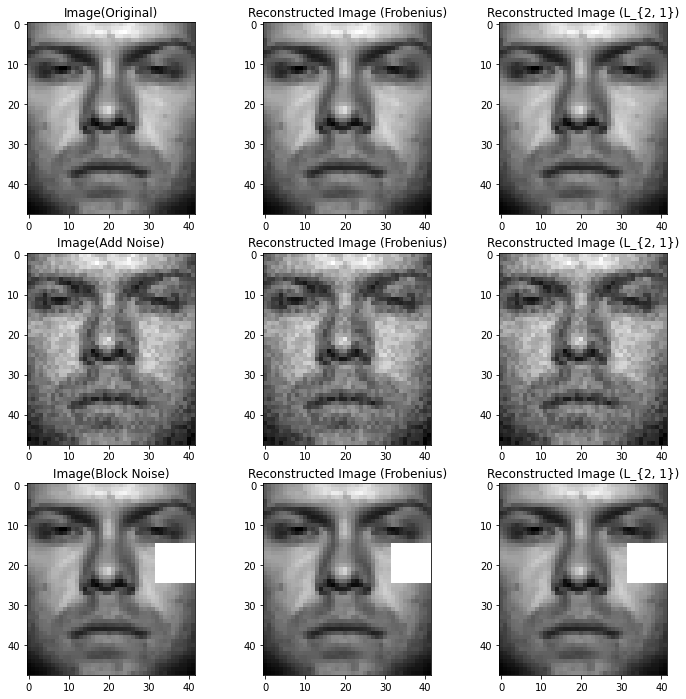

In [ ]:
# Visualization for YaleB dataset reconstruction

# Choose an arbitary example from the ORL dataset
sample_ID = 1
# Original
sample_YaleB = X_YaleB[:, sample_ID].reshape((1, -1))
# With random additional noise
sample_ORl_add = X_add_noise_YaleB[:, sample_ID].reshape((1, -1))
# With random block noise
sample_ORl_bc = X_bc_noise_YaleB[:, sample_ID].reshape((1, -1))

# Reconstruction by Frobenius norm NMF
D_L2, R_L2, _ = mf_multiplicative_update_L2(X = sample_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
D_add_L2, R_add_L2, _ = mf_multiplicative_update_L2(X = sample_ORl_add, k = opt_k_YaleB, max_steps = 5000, random_state = False)
D_bc_L2, R_bc_L2, _ = mf_multiplicative_update_L2(X = sample_ORl_bc, k = opt_k_YaleB, max_steps = 5000, random_state = False)

re_X = D_L2.dot(R_L2)
re_add_X = D_add_L2.dot(R_add_L2)
re_bc_X = D_bc_L2.dot(R_bc_L2)

# Reconstruction by L_{2, 1} norm NMF
D_L21, R_L21, _ = mf_multiplicative_update_L21(X = sample_YaleB, k = opt_k_YaleB, max_steps = 5000, random_state = False)
D_add_L21, R_add_L21, _ = mf_multiplicative_update_L21(X = sample_ORl_add, k = opt_k_YaleB, max_steps = 5000, random_state = False)
D_bc_L21, R_bc_L21, _ = mf_multiplicative_update_L21(X = sample_ORl_bc, k = opt_k_YaleB, max_steps = 5000, random_state = False)

re_L21_X = D_L21.dot(R_L21)
re_add_L21_X = D_add_L21.dot(R_add_L21)
re_bc_L21_X = D_bc_L21.dot(R_bc_L21)

# Visualize the reconstructed images
print('==> YaleB dataset reconstruction visualization')
img_size = [42, 48] # YaleB (42, 48)
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.imshow(sample_YaleB.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(332)
plt.imshow(re_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(333)
plt.imshow(re_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

plt.subplot(334)
plt.imshow(sample_ORl_add.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Add Noise)')
plt.subplot(335)
plt.imshow(re_add_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(336)
plt.imshow(re_add_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

plt.subplot(337)
plt.imshow(sample_ORl_bc.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Block Noise)')
plt.subplot(338)
plt.imshow(re_bc_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (Frobenius)')
plt.subplot(339)
plt.imshow(re_bc_L21_X.reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Reconstructed Image (L_{2, 1})')

# Save the figure
plt.savefig('reconstruct_YaleB.pdf')
plt.show()
